In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

import cv2
from cv2 import dilate
from cv2 import adaptiveThreshold

from os import listdir
from os.path import isfile, join

from skimage.morphology import *
from skimage import io

In [5]:
def cv_remove_small_objects(im, min_size):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(im, connectivity=8)
    sizes = stats[1:, -1]; 
    nb_components = nb_components - 1

    res = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            res[output == i + 1] = 1
            
    return res

def binarize(im):
    binary_local = im=cv2.adaptiveThreshold(
        src=np.array(cv2.medianBlur(im, 5), dtype=np.uint8), 
        maxValue=255, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=505, 
        C=25)
    
    cleaned = cv_remove_small_objects(binary_local, 250)
    
    strel = cv2.getStructuringElement(cv2.MORPH_RECT,(40, 40))    
    cleaned = cv2.dilate(np.array(cleaned, dtype=np.uint8), strel)
    
    cleaned = cv_remove_small_objects(cleaned, 15000)
    
    return cleaned

def ImageToFeatures(img):
    data = []
    labels = []
    for i, row in enumerate(img):
        for j, val in enumerate(row):
            if val:
                data.append([j, i])
                labels.append(val)    
    return np.array(data), np.array(labels)

def FeaturesToImage(fts, width, height, correction=False):
    minx = min(fts[:, 0])
    miny = min(fts[:, 1])

    maxx = max(fts[:, 0])
    maxy = max(fts[:, 1])
    
    image = np.zeros((width, height))
    
    if correction:
        ft_width = maxx-minx
        ft_height = maxy-miny
        if ft_width > width or ft_height > height:
            return np.ones((width, height))
        indent_width = int((width-ft_width)/2)
        indent_height = int((height-ft_height)/2)
        for x, y in fts:
            image[y-miny+indent_height-1, x-minx+indent_width-1] = 1
    else:
        for x, y in fts:
            image[y, x] = 1
            
    return image

def n_clusters(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)

def get_tracings_from_binarized_image(image, notch_size=700):
    nb_components, output, stats, centroids = \
        cv2.connectedComponentsWithStats(np.array(image, dtype=np.uint8), connectivity=4)
    pixels, labels = ImageToFeatures(output)
    
    n_clt = n_clusters(labels)
    
    clusters = [np.where(labels==i)[0] for i in range(1, n_clt + 1)]
    
    notches=[]
    for cluster in clusters:
        notches.append([pixels[ix] for ix in cluster])
    notches = np.array(notches)
    
    data=list(map(lambda x: FeaturesToImage(np.array(x), width=notch_size, height=notch_size, correction=True), notches))
    data_src=list(map(lambda x: FeaturesToImage(np.array(x), width=image.shape[0], height=image.shape[1]), notches))
    
    data_prep = []
    for dt in data:
        if dt is not None:
            data_prep.append(dt.reshape(notch_size**2))
        else:
            data_prep.append(np.zeros(notch_size**2))
            
    return (data, data_src, data_prep)

In [217]:
path=os.getcwd() + '\\photo1\\'
impaths = [f for f in listdir(path) if isfile(join(path, f))]

In [527]:
%%time
data = []
data_src = []
data_prep = []
for n, impath in enumerate(impaths):
    print("processing " + impath + " {} of {}".format(n+1, len(impaths)))
    image = cv2.imread(path+impath, cv2.IMREAD_GRAYSCALE)
    bimage = binarize(image)
    d, d_src, d_prep = get_tracings_from_binarized_image(bimage)
    data += d
    #data_src += d_src
    #data_prep += d_prep    

processing 20180810_0056.jpg 1 of 54
processing 20180810_0057.jpg 2 of 54
processing 20180810_0058.jpg 3 of 54
processing 20180810_0059.jpg 4 of 54
processing 20180810_0060.jpg 5 of 54
processing 20180810_0061.jpg 6 of 54
processing 20180810_0062.jpg 7 of 54
processing 20180810_0063.jpg 8 of 54
processing 20180810_0064.jpg 9 of 54
processing 20180810_0065.jpg 10 of 54
processing 20180810_0066.jpg 11 of 54
processing 20180810_0067.jpg 12 of 54
processing 20180810_0068.jpg 13 of 54
processing 20180810_0069.jpg 14 of 54
processing 20180810_0070.jpg 15 of 54
processing 20180810_0071.jpg 16 of 54
processing 20180810_0072.jpg 17 of 54
processing 20180810_0073.jpg 18 of 54
processing 20180810_0074.jpg 19 of 54
processing 20180810_0075.jpg 20 of 54
processing 20180810_0076.jpg 21 of 54
processing 20180810_0077.jpg 22 of 54
processing 20180810_0078.jpg 23 of 54
processing 20180810_0079.jpg 24 of 54
processing 20180810_0080.jpg 25 of 54
processing 20180810_0081.jpg 26 of 54
processing 20180810_0

In [528]:
len(data)

336

In [7]:
import pickle

#with open('outfile', 'wb') as fp:
#    pickle.dump(data, fp)
    
with open ('outfile', 'rb') as fp:
    data = pickle.load(fp)

In [1384]:
image = cv2.imread(path+impaths[42], cv2.IMREAD_GRAYSCALE)
bimage = binarize(image)
d, d_src, d_prep = get_tracings_from_binarized_image(bimage)
print(len(d))

5


0 - мусор<br>
1 - засвет<br>
2 - крест<br>
3 - круг<br>
4 - горизонтальная засечка<br>
5 - вертикальная засечка<br>

In [200]:
labels = [
    #0
    2, 0, 1, 2, 0, #4
    #1
    2, 1, 2, 5, 0, #9
    #2
    2, 5, 5, 0, 1, 0, #15
    #3
    5, 5, 5, 1, 0, #20
    #4
    5, 5, 5, 1, #24
    #5
    5, 5, 5, 1, #28
    #6    
    5, 5, 5, 1, #32
    #7
    5, 5, 5, 1, #36
    #8
    5, 5, 5, 1, #40
    #9
    5, 5, 5, 1, #44
    #10
    5, 5, 5, 1, #48
    #11
    5, 5, 5, 1, #52
    #12
    5, 5, 5, 1, #56
    #13
    5, 5, 5, 0, 1, #61
    #14
    5, 5, 5, 0, 1, #66
    #15
    2, 5, 5, 0, 1, #71
    #16
    2, 5, 1, 4, 2, 5, 1, #78
    #17    
    0, 2, 1, 5, 0, 0, 4, 2, 0, #87
    #18
    4, 0, 1, 0, 2, 0, 0, 5, 0, 0, 5, 1, #99
    #19
    4, 0, 1, 1, 5, 2, 1, #106
    #20
    4, 1, 1, 4, 0, 1, 0, #113
    #21
    4, 1, 0, 4, 1, 4, #119
    #22
    4, 1, 0, 1, 4, 1, 1, 4, 0, #128
    #23
    4, 0, 0, 1, 4, 5, 0, 4, 1, #137
    #24
    4, 1, 1, 1, 4, 0, 0, 4, 1, #146
    #25
    2, 0, 0, 1, 5, 4, 1, 1, 4, 1, #156
    #26
    2, 1, 1, 0, 2, 1, 0, 4,  #164
    #27
    0, 0, 1, 0, 1, 2, 0, 2, 1, #173
    #28
    1, 1, 2, 5, 1, #178
    #29    
    0, 1, 5, 2, 5, 1, 1, #184
    #30
    1, 5, 5, 5, 1, 1, #190
    #31
    0, 0, 5, 5, 5, 1, 1, #197
    #32
    1, 5, 5, 5, 1, 0, #203
    #33
    0, 5, 5, 5, 0, 1, 0, #210
    #34
    5, 5, 5, 0, 0, 1, 1, #217
    #35
    5, 5, 5, 0, 0, #222
    #36
    5, 5, 5, 1, 0, #227
    #37
    5, 5, 5, 0, 0, #232
    #38
    5, 5, 5, 0, 0, #237
    #39
    5, 5, 5, 0, 0, 0, #243
    #40
    5, 5, 5, 0, 0, 0, #249
    #41
    5, 5, 2, 0, 0, #254
    #42
    1, 5, 2, 2, 0, #259 !
    #43
    1, 2, 2, 0, 1, 0, #266 !
    #44
    1, 2, 2, 0, 1, 0, #272
    #45
    2, 4, 0, 1, 4, 0, #278
    #46
    4, 0, 4, 1, 0, 4, 1, #285
    #47    
    4, 0, 0, 4, 5, 1, 0, 1,
    #48
    4, 0, 4, 0, 0, 0, 1, 
    #49
    4, 0, 0, 4, 0, 0, 1,
    #50
    4, 0, 0, 4, 1, 0, 1, 
    #51
    4, 0, 4, 1, 0, 1, 
    #52
    4, 0, 0, 4, 1, 1, 0, #327
    #53
    4, 0, 2, 5, 1, 0, 1, 1    
]

In [12]:
labels = [0 if l in (0, 1, 2, 3) else 1 for l in labels]

0 - мусор<br>
1 - засвет<br>
2 - крест<br>
3 - круг<br>
4 - горизонтальная засечка<br>
5 - вертикальная засечка<br>

1


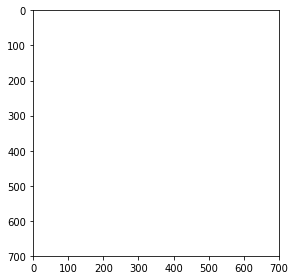

In [207]:
i=325
print(labels[i])
io.imshow(data[i])